# Table of Contents

- #### [Imports and data overview](#overview)
    - ####   View static dataset
    - #### Working with Dynamic dataset


# Goal
### The intention is not to create highly performant regression models, but rather to display the functionality and workflow of Spark.

# Imports and OverView

In [140]:
import pandas as pd 
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, col, when, count, avg, round, expr, array, stddev, regexp_extract, substring, when, max, min
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType
from pyspark.ml.evaluation import RegressionEvaluator

#For Models:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor

#For iterations
import itertools

#For One Hot Encoding:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler

#For de-vectorization
from pyspark.ml.functions import  vector_to_array

#For visualizing distributions
import seaborn as sns
import matplotlib.pyplot as plt

#For statistical analysis
from sklearn.metrics import r2_score

In [5]:
spark = SparkSession.builder.master("local").appName("health").getOrCreate()

In [4]:
spark.sparkContext.setLogLevel("ERROR")

### Get and view static Dataset

In [6]:
df = spark.read.csv("health_data_static/gym_members_exercise_tracking.csv", inferSchema=True, header=True)
#Let's view head(3), to see what the dataset we have in question
df.show(n=3)
#Number of rows:
print(f"static number of rows: {df.count()}")

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|                     1.3|          883.0|        HIIT|          33.9|                  2.1|              

In [148]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Weight_(kg): float (nullable = true)
 |-- Height_(m): float (nullable = true)
 |-- Max_BPM: integer (nullable = true)
 |-- Avg_BPM: integer (nullable = true)
 |-- Resting_BPM: integer (nullable = true)
 |-- Session_Duration_(hours): float (nullable = true)
 |-- Calories_Burned: float (nullable = true)
 |-- Workout_Type: string (nullable = true)
 |-- Fat_Percentage: float (nullable = true)
 |-- Water_Intake_(liters): float (nullable = true)
 |-- Workout_Frequency_(days/week): integer (nullable = true)
 |-- Experience_Level: integer (nullable = true)
 |-- BMI: float (nullable = true)



Count # of Nulls: We will not need to worry about transforming out dataset to take care of nulls

In [8]:
df.select([count(when(isnan(col), col)).alias(f"{col}_null") for col in df.columns]).show()

+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|Age_null|Gender_null|Weight (kg)_null|Height (m)_null|Max_BPM_null|Avg_BPM_null|Resting_BPM_null|Session_Duration (hours)_null|Calories_Burned_null|Workout_Type_null|Fat_Percentage_null|Water_Intake (liters)_null|Workout_Frequency (days/week)_null|Experience_Level_null|BMI_null|
+--------+-----------+----------------+---------------+------------+------------+----------------+-----------------------------+--------------------+-----------------+-------------------+--------------------------+----------------------------------+---------------------+--------+
|       0|          0|               0|              0|           0|           0|               0|                            0|                   0|        

# Static Dataset Cleaning
Let's one hot encode gender and workout type to work on it further:

In [14]:
#We would typically reduce the size of the vectors after one-hot encoding by one to avoid multicolinearity, but vectorAssembler will have issues converting empty sets
indexers= [StringIndexer(inputCol= column, outputCol= column + "Indexed") for column in ['Gender', 'Workout_Type']]
one_hot_encoders = [OneHotEncoder(inputCol = column + "Indexed", outputCol= column+"Encoded", dropLast=False) for column in ['Workout_Type']] #Gender is already in it's reduced form
stages = indexers+one_hot_encoders
pipeline = Pipeline(stages=stages)

model = pipeline.fit(df)
#Let's remove the previous columns that are no longer necessary
df_transformed = model.transform(df).drop("Workout_TypeIndexed", "Workout_Type", "Gender").withColumnRenamed("GenderIndexed", "Gender").withColumnRenamed("Workout_TypeEncoded", "Workout_Type").withColumnRenamed("Gender", "Gender_Female")

In [15]:
#Our new dataset should now be ready for further analysis, and machine learning! The Workout_Type is represented by a set in the form (vector size, [index of vector], [value at index]). Dropping one value improves our ability to develop ML models by reducing the correlation.
df_transformed = df_transformed.withColumn("Workout_Type_String", col("Workout_Type").cast("String"))
df_transformed.select(col("Workout_Type")).show(n=5)

+-------------+
| Workout_Type|
+-------------+
|(4,[2],[1.0])|
|(4,[3],[1.0])|
|(4,[1],[1.0])|
|(4,[0],[1.0])|
|(4,[0],[1.0])|
+-------------+
only showing top 5 rows



In [16]:
size_workout_type = int(df_transformed.select(col("Workout_Type_String")).head()[0][1])
print(f"There are {size_workout_type} workout types, this is correct")

There are 4 workout types, this is correct


We want to get back to a format with separate columns for each workout_type, so we will use a substring to get the value of the index where the value is 1.

In [17]:
df_transformed_3 = df_transformed.withColumn("Workout_Type", regexp_extract(substring(col("Workout_Type_String"), 4,3), r"\d+", 0).cast("Integer"))

As you can see, we now have the index of the 1 values. This let us show the capabilities of regexp_extract, cast, as well as other functions.

In [18]:
df_transformed_3.select("Workout_Type").show(n=3)

+------------+
|Workout_Type|
+------------+
|           2|
|           3|
|           1|
+------------+
only showing top 3 rows



In [21]:
workout_map = {index: label for index, label in enumerate(indexer.labels)}
print(workout_map)

{0: 'Strength', 1: 'Cardio', 2: 'Yoga', 3: 'HIIT'}


In [22]:
for n, workout in list(zip(workout_map.keys(), workout_map.values())):
    df_transformed_3 = df_transformed_3.withColumn(f"{workout}_Workout", when(col("Workout_Type") == n, 1).otherwise(0))

Let's look at our transformations!

In [23]:
workout_cols = [col for col in df_transformed_3.columns if "Workout" in col]
df_transformed_3.select([col(x) for x in workout_cols]).show(n=4)

+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|Workout_Frequency (days/week)|Workout_Type|Workout_Type_String|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
|                            4|           2|      (4,[2],[1.0])|               0|             0|           1|           0|
|                            4|           3|      (4,[3],[1.0])|               0|             0|           0|           1|
|                            4|           1|      (4,[1],[1.0])|               0|             1|           0|           0|
|                            3|           0|      (4,[0],[1.0])|               1|             0|           0|           0|
+-----------------------------+------------+-------------------+----------------+--------------+------------+------------+
only showing top

Let's drop the vectorized Workout type column as well as the categorical Workout_Type and hold this transformed dataset under a new dataframe object

In [24]:
df_final = df_transformed_3.drop(col("Workout_Type_String"), col("Workout_Type"))

Our newest dataset looks like so:

In [25]:
df_final.show(n=3)

+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
|Age|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|
+---+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+-----+-------------+----------------+--------------+------------+------------+
| 56|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|          12.6|                  3.5|                            4|               3| 30.2|          0.0|               0|  

### Train/Test split

First, let's create a train and test set with 15% of our transformed dataset. Spark typically works with large datasets, so a test set size of 20% would usually be more fitting.

In [26]:
train_set, test_set = df_final.randomSplit([0.85,0.15], seed=11)

# Data Visualization With Pandas

Let's turn our pyspark dataframe into a Pandas version to perform visual analysis:

In [30]:
#Turn on an Arrow optimization to make spark to Pandas conversions more efficient:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
df_train = train_set.toPandas()

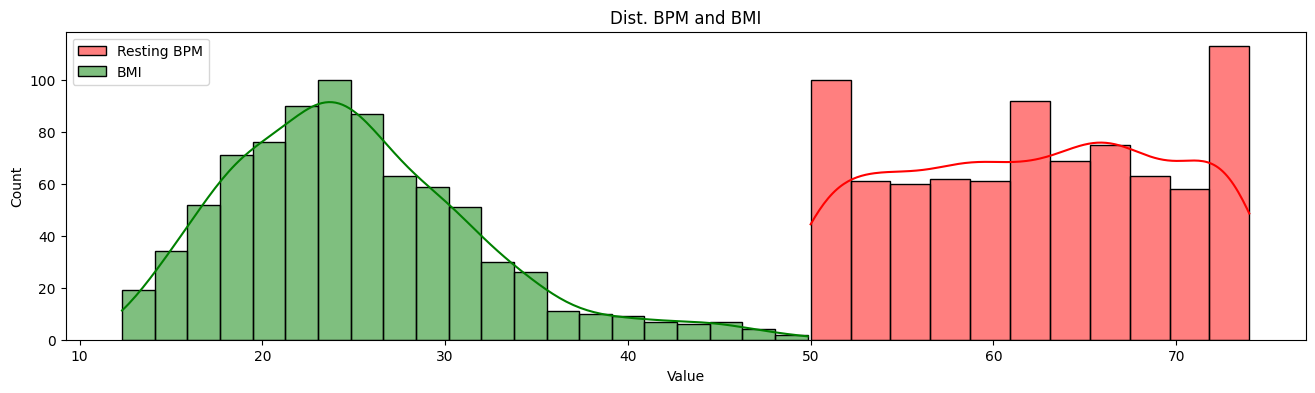

In [46]:
#Let's check the distribution
fig, axs = plt.subplots(1,1, figsize=(16,4), sharex = True)
sns.histplot(df_train['Resting_BPM'], color="red", kde=True,label='Resting BPM')#, ax=axs[0])
sns.histplot(df_train['BMI'], color="green", kde=True, label='BMI')#ax=axs[0])
plt.legend()
plt.xlabel('Value')
plt.title('Dist. BPM and BMI')
plt.show()

The distribution of the resting heart rate is non-normal given the state of the edges. I will assume that there is something wrong with the methodology, data, or the sample is too small. Regardless, we will proceed.

Let's address colinearity. Creating a correlation dataframe with boolean values based on whether or not the correlation value is higher than 0.8 will show us which features we will have to address.

In [47]:
correlation_df = df_train.corr() >.8
#Which columns have high correlation?
correlation_df.sum()>1

Age                              False
Weight (kg)                       True
Height (m)                       False
Max_BPM                          False
Avg_BPM                          False
Resting_BPM                      False
Session_Duration (hours)          True
Calories_Burned                   True
Fat_Percentage                   False
Water_Intake (liters)            False
Workout_Frequency (days/week)     True
Experience_Level                  True
BMI                               True
Gender_Female                    False
Strength_Workout                 False
Cardio_Workout                   False
Yoga_Workout                     False
HIIT_Workout                     False
dtype: bool

Where is this colinearity found? Let's look at the correlation dataframe to determine and drop one of each column

In [48]:
correlation_df

,Age,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),Experience_Level,BMI,Gender_Female,Strength_Workout,Cardio_Workout,Yoga_Workout,HIIT_Workout
Age,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Weight (kg),False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
Height (m),False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Max_BPM,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
Avg_BPM,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
Resting_BPM,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
Session_Duration (hours),False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
Calories_Burned,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False
Fat_Percentage,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
Water_Intake (liters),False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [49]:
df_train = df_train.drop(columns=["Weight (kg)", "Calories_Burned", "Experience_Level"], axis=1)

What do the scatter plots look like when compoaring to every variable? It doesn't seem like there's an obvious connection. Surprisingly

### Resting BPM vs all non-categorical data:

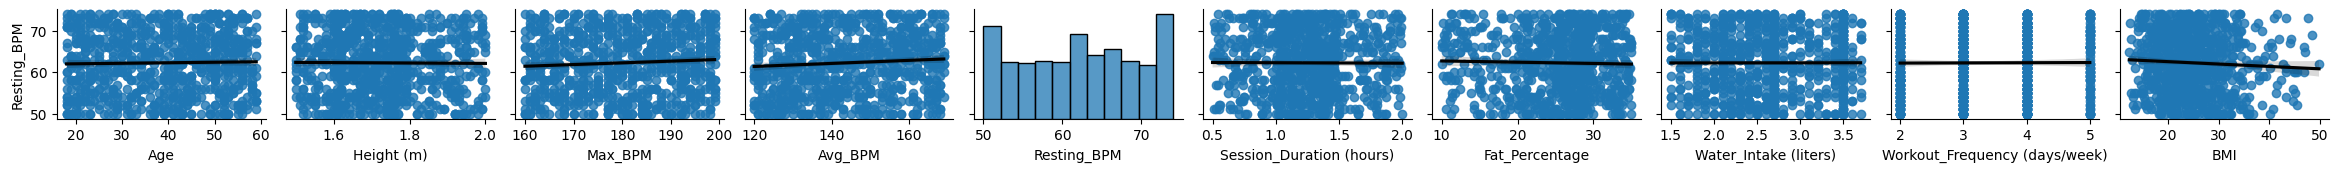

In [50]:
#Excluding one hot encoded data
sns.pairplot(df_train.loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=1.7, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})

With the correlations as follows

In [51]:
np.round(df_train.corr().loc['Resting_BPM'],3)

Age                              0.021
Height (m)                      -0.009
Max_BPM                          0.065
Avg_BPM                          0.072
Resting_BPM                      1.000
Session_Duration (hours)        -0.005
Fat_Percentage                  -0.025
Water_Intake (liters)            0.002
Workout_Frequency (days/week)    0.005
BMI                             -0.054
Gender_Female                   -0.005
Strength_Workout                 0.010
Cardio_Workout                  -0.009
Yoga_Workout                    -0.034
HIIT_Workout                     0.033
Name: Resting_BPM, dtype: float64

Surprisingly, Resting Heart Rate is extremely poorly correlated with any of this data! What about if we focused on categorical groups, such as by Gender with a certain exercise type... Will we be able to find any significant relationship?

#### Resting BPM vs all non-categorical data for Males that perform Strength Workouts:

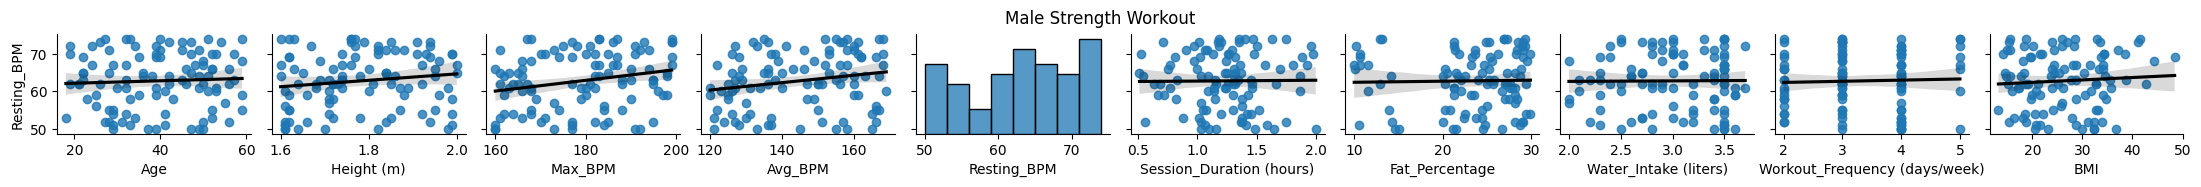

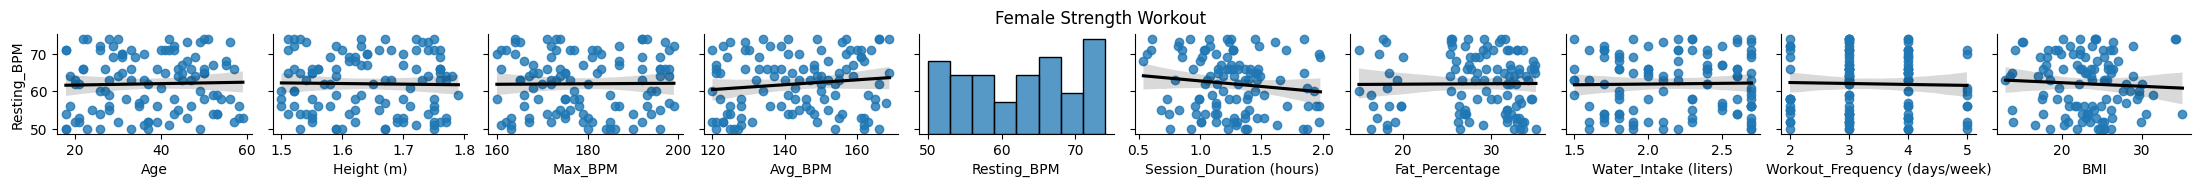

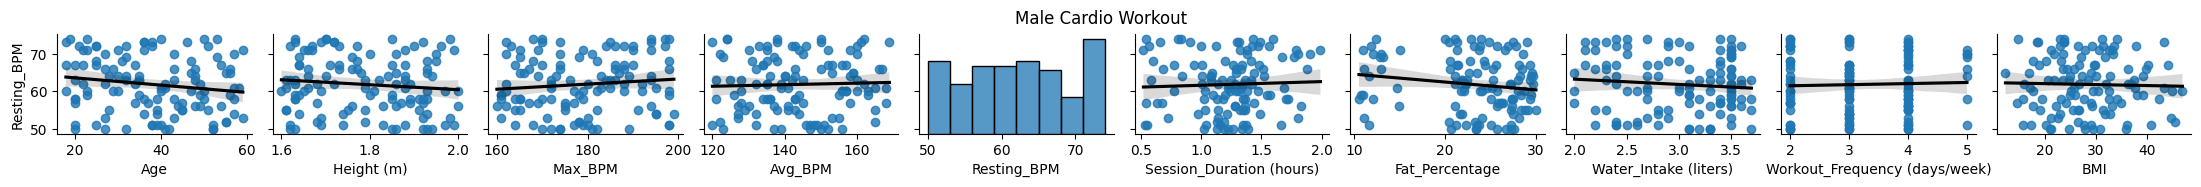

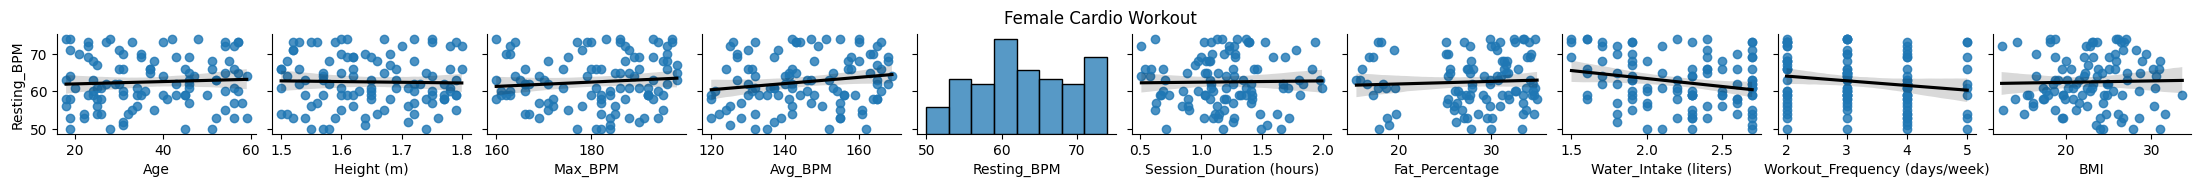

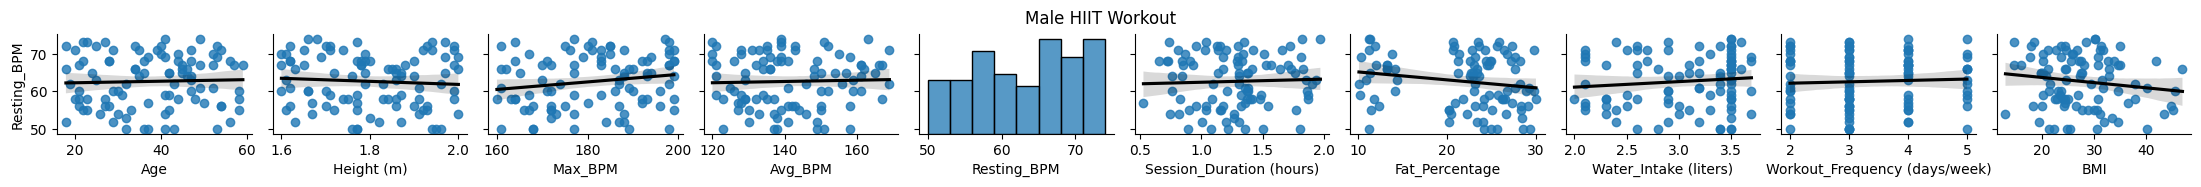

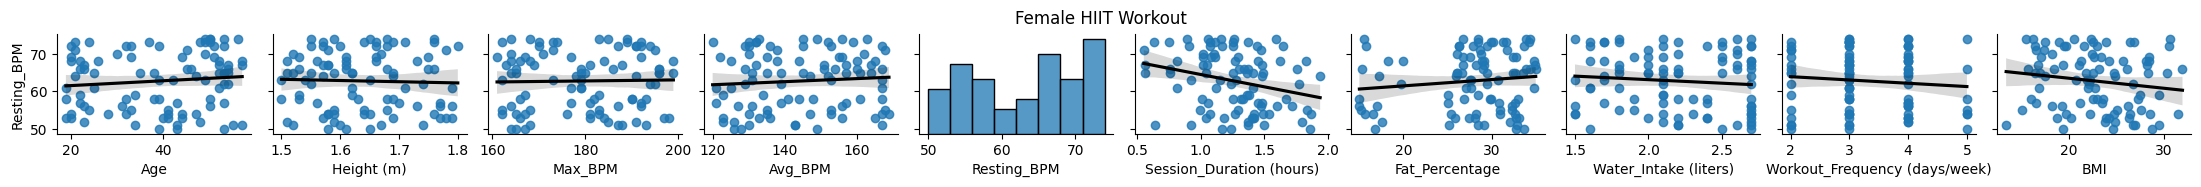

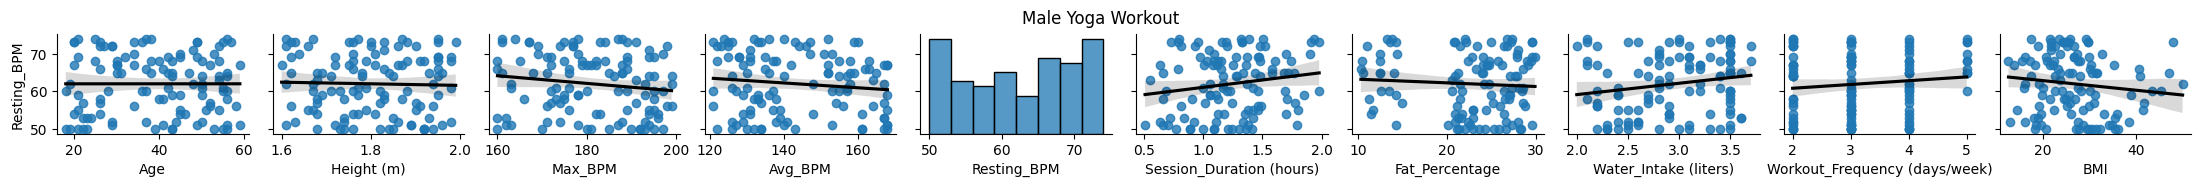

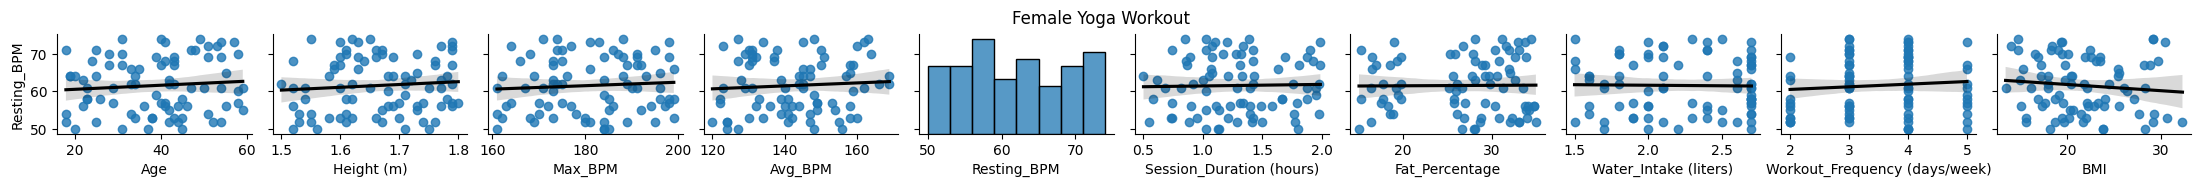

In [53]:
df_corr_all = pd.DataFrame(np.round(df_train.corr().loc['Resting_BPM'],3)).rename(columns={'Resting_BPM':"All"})
df_corr_all.index.name = 'Correlation to Resting_BPM'


for workout, gender in list(itertools.product([workout for workout in ['Strength', 'Cardio', 'HIIT', 'Yoga']],[gender for gender in ['Male', 'Female']])):
    gender_female_int = 1 if gender == "Female" else 0
    corr_df = pd.DataFrame(np.round(df_train.query(f'{workout}_Workout==1 and Gender_Female == {gender_female_int}').corr().loc['Resting_BPM'],3)).rename(columns={'Resting_BPM':f"{gender}_{workout}"})
    df_corr_all = pd.concat([df_corr_all, corr_df], axis = 1)
    #Add pairplot for each Gender/Workout comparing the scatter plots and best fitting linear regression between resting BPM and all other non-categorical features
    chart =sns.pairplot(df_train.query(f'Gender_Female == {gender_female_int} and {workout}_Workout==1').loc[:,:'BMI'], kind='reg', y_vars='Resting_BPM', height=1.6, aspect=1.4, plot_kws={'line_kws': {'color':'black'}})
    chart.fig.suptitle(f"{gender} {workout} Workout", y=1.1)


### Now let's check Pearson's Correlation

<Axes: >

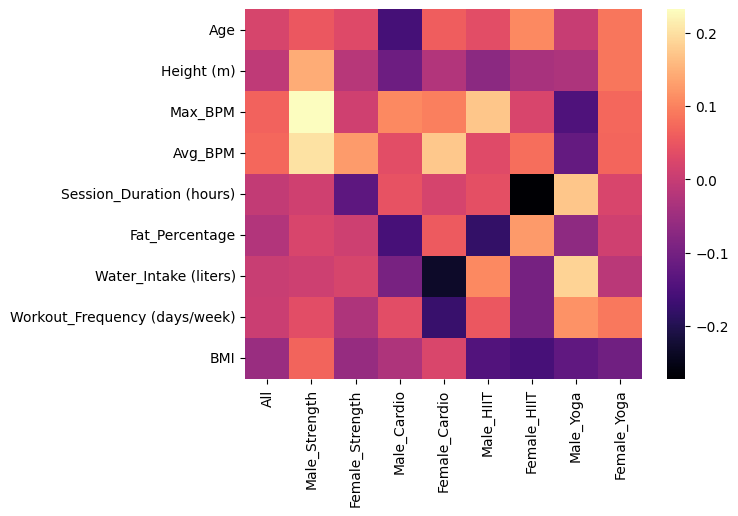

In [55]:
df_corr = df_corr_all.loc[[index for index in df_corr_all.index if index != "Resting_BPM"]]
#df_corr_all[[c for c in df_cor_all.columns if c !='Resting_BPM']]
sns.heatmap(df_corr.loc[:'BMI', :][[c for c in df_corr.columns if c !='Resting_BPM']], cmap='magma')

Interestingly, gender and workout type seem to have somewhat important roles in helping us determine how best to optimize your workout in order to decrease your resting heart rate! Simply disregarding gender and workout type may not help one determine how to best minimize Resting BPM. The correlation values are very insignificant, so not many conclusions can be drawn. For example, although counter-intuitive, if one is a male performing HIIT, increasing fat_percentage is positively correlated with a falling resting heart rate. This goes against common sense but for the sake of this project, we will assume that these correlations have some basis in reality. However for females performing HIIT, a higher fat percentage is correlated with a higher resting heart rate, and a rising session duration is postively correlated with a lowering heart rate, as one would expect. The other most positively correlated feature is Max_BPM for male strength exercises. If a male performing strength training hits a higher max heart rate, this might imply that he has a higher resting heart rate as well. We can't make too many conclusions from this data, however, given the poor correlation values.

# Data Cleaning II

We would like to scale our values before training in on a machine learning algorithm. To do this, we will need to determine which columns will need scaling. Specifically the ones that are not one-hot encoded... Then we will vectorize these columns, scale said vector using StandardScaler, turn them into an array and transform array items back into the dataframe non-array format.

In [89]:
cols_for_scaling = [col for col in df_final.columns if "_Workout" not in col and "Gender_" not in col and 'Resting_BPM' not in col]
print(cols_for_scaling)

['Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM', 'Session_Duration (hours)', 'Calories_Burned', 'Fat_Percentage', 'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'Experience_Level', 'BMI']


In [90]:
assembler = VectorAssembler(inputCols= cols_for_scaling, outputCol='vector')
#Vectorize both the training and test sets
train_vectorized = assembler.transform(train_set)
test_vectorized = assembler.transform(test_set)

The output vector looks like so (it does not include Resting Heart Rate as this will be what we will try to predict using the vector column):

In [92]:
train_vectorized.select(col('vector')).show(n=1)

+--------------------+
|              vector|
+--------------------+
|[18.0,50.7,1.53,1...|
+--------------------+
only showing top 1 row



Now create a scaled column based on the vector column and drop initial vector column

In [94]:
scaler = StandardScaler(inputCol="vector",outputCol="scaled_vector", withMean=True, withStd=True)
scl = scaler.fit(train_vectorized)

#Now we create the scaled dataframe with OHE columns
train_scaled = scl.transform( train_vectorized).drop(col("vector"))

test_scaled = scl.transform( test_vectorized).drop("vector")

train_scaled.select(col("scaled_vector")).show(n=1)

+--------------------+
|       scaled_vector|
+--------------------+
|[-1.6836115013544...|
+--------------------+
only showing top 1 row



Let's turn our vector back into a format that would be easier to visualize via a dataframe. For each element in our vector, add it as a new dataframe column. Loop through the following columns using enumerate to get the vector location.

In [96]:
for n, column in enumerate(cols_for_scaling):
    train_scaled = train_scaled.withColumn("array", vector_to_array("scaled_vector")).withColumn(column, col("array")[n])#.show(n=3)
    test_scaled = test_scaled.withColumn("array", vector_to_array("scaled_vector")).withColumn(column, col("array")[n])

In [97]:
train_scaled.show(n=4)

+-------------------+-------------------+--------------------+-------------------+------------------+-----------+------------------------+-------------------+------------------+---------------------+-----------------------------+-------------------+--------------------+-------------+----------------+--------------+------------+------------+--------------------+--------------------+
|                Age|        Weight (kg)|          Height (m)|            Max_BPM|           Avg_BPM|Resting_BPM|Session_Duration (hours)|    Calories_Burned|    Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|   Experience_Level|                 BMI|Gender_Female|Strength_Workout|Cardio_Workout|Yoga_Workout|HIIT_Workout|       scaled_vector|               array|
+-------------------+-------------------+--------------------+-------------------+------------------+-----------+------------------------+-------------------+------------------+---------------------+-----------------------------+-

Now our data has scaled data covering BMI, etc. as well as One Hot Encoded data such as Gender_Female and workout type, as well as the vector and array versions of this.

All of our data should now be scaled. For example average heart rate is given 1.5 standard deviations around a mean of 0.

/Users/kirillklimov/Python/miniforge3/envs/2024Env/lib/python3.12/site-packages/pyspark/sql/pandas/conversion.py:117: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


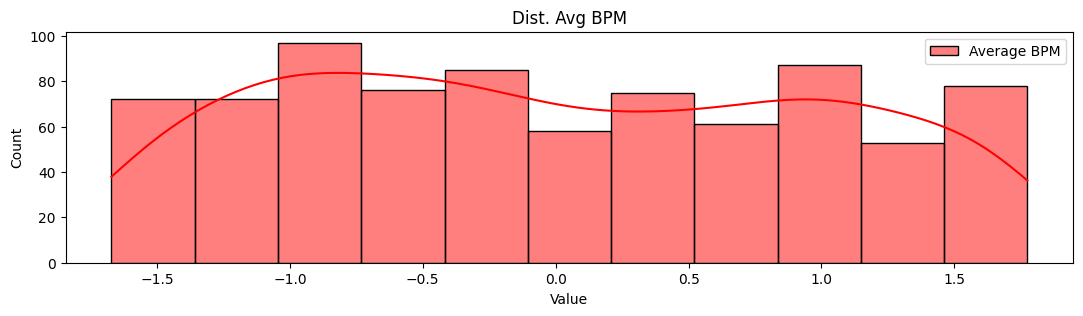

In [99]:
#Let's check the distributions
df_train = train_scaled.toPandas()
fig, axs = plt.subplots(1,1, figsize=(13,3), sharex = True)
sns.histplot(df_train['Avg_BPM'], color="red", kde=True,label='Average BPM')
plt.legend()
plt.xlabel('Value')
plt.title('Dist. Avg BPM')
plt.show()

# Creating a model and further analysis

Get the vector from our Spark DataFrame to train our regression models. We will test both a linear regression model as is the custom, as well as a decision tree regressor. Why a decision tree regressor? As you can tell by looking at the Heart Rate distribution, it does not resemble a standard normal one. In fact, it has cutoffs at the -1.5, 1.5 standard deviation marks, which I think is the cumulative sum of all values past a certain value in the original dataset. Given these data abnormalities, a decision tree model can use different logic for different cases.

Get X and Y data for each set of data

It can be helpful for gradient descent when the target column (Resting BPM in our case) is scaled as well. However, it is something we will forego as it is not necessary.

In [100]:
linear = LinearRegression(featuresCol="scaled_vector", labelCol='Resting_BPM')
decision_tree = DecisionTreeRegressor(featuresCol="scaled_vector",labelCol='Resting_BPM')

linear_model = linear.fit(train_scaled)
decision_tree_model = decision_tree.fit(train_scaled)

#Predict data:
linear_test_prediction = linear_model.transform(test_scaled)
decision_tree_test_prediction = decision_tree_model.transform(test_scaled)

### Linear Regression Prediction

In [105]:
evaluator = RegressionEvaluator(labelCol="Resting_BPM", predictionCol = "prediction")

In [111]:
linear_target_vs_prediction = linear_test_prediction.select(col("Resting_BPM"),col("prediction"))
print("The Root Mean Squared Error using Linear Regression is: ", np.round(evaluator.evaluate(linear_target_vs_prediction),2))

The Root Mean Squared Error using Linear Regression is:  7.38


Add a Linear Regression line to our scatter plot. The slope should be roughly one.

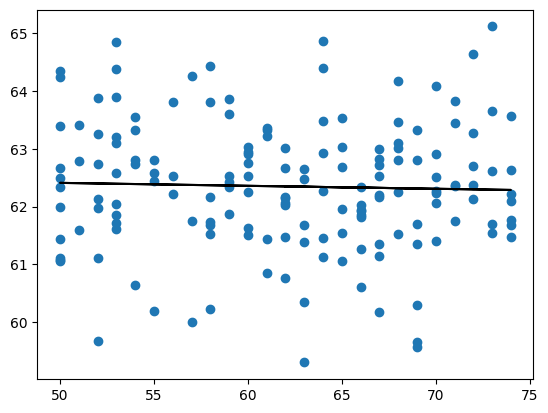

In [116]:
linear_df = linear_target_vs_prediction.toPandas()
slope, i = np.polyfit(linear_df['Resting_BPM'], linear_df['prediction'], 1)
line = slope*linear_df['Resting_BPM'] + i
plt.plot(linear_df['Resting_BPM'], line, color='black')
plt.scatter(linear_df['Resting_BPM'], linear_df['prediction'])

In [120]:
r2 = np.round(r2_score(linear_df['prediction'], linear_df['Resting_BPM']),3)

In [123]:
print(f"The slope of the linear regression model on the actual vs predicted values is {np.round(slope,3)}, but should ideally be 1 \nThe r2 score should ideally be 1 but is {r2}")

The slope of the linear regression model on the actual vs predicted values is -0.005, but should ideally be 1 
The r2 score should ideally be 1 but is -42.64656219907201


### Decision Tree Regression Prediction

In [125]:
decision_tree_target_vs_prediction = decision_tree_test_prediction.select(col ("Resting_BPM"), col("prediction"))
print("The Root Mean Squared Error using Decision Tree Regression is: ", np.round(evaluator.evaluate(decision_tree_target_vs_prediction),2))

The Root Mean Squared Error using Decision Tree Regression is:  7.72


The typical error is actually worse than that of the linear regressor.

What about the attributes of the decision tree regressor itself? What is the depth?

In [132]:
print("The model depth is :", decision_tree_model.depth)

The model depth is : 5


What are the weights given to each feature?

In [131]:
list(zip(cols_for_scaling, decision_tree_model.featureImportances))

[('Age', 0.13428166641093947),
 ('Weight (kg)', 0.05271152084314049),
 ('Height (m)', 0.13153278314144012),
 ('Max_BPM', 0.10022109344832082),
 ('Avg_BPM', 0.10046095068836082),
 ('Session_Duration (hours)', 0.0020013381080128383),
 ('Calories_Burned', 0.1998544482397794),
 ('Fat_Percentage', 0.05873807839270925),
 ('Water_Intake (liters)', 0.10260193664900327),
 ('Workout_Frequency (days/week)', 0.0),
 ('Experience_Level', 0.061802244784000364),
 ('BMI', 0.055793939294293174)]

Calories Burned, and Age are the two most important features according to our poorly performing regression model

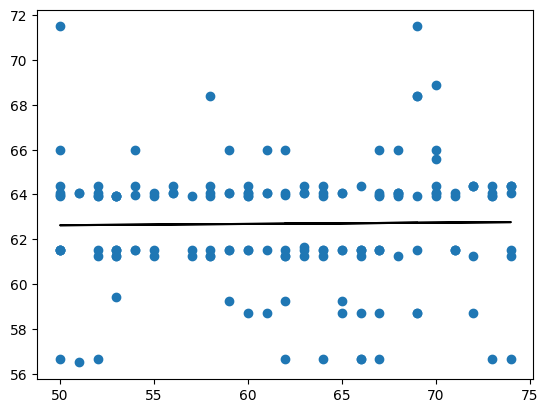

In [133]:
tree_df = decision_tree_target_vs_prediction.toPandas()
slope, i = np.polyfit(tree_df['Resting_BPM'], tree_df['prediction'], 1)
line = slope*tree_df['Resting_BPM'] + i
plt.plot(tree_df['Resting_BPM'], line, color='black')
plt.scatter(tree_df['Resting_BPM'], tree_df['prediction'])

In [143]:
r2 = np.round(r2_score(tree_df['prediction'], tree_df['Resting_BPM']),3)

In [144]:
print(f"The slope of the Decision Tree regression model on the actual vs predicted values is {np.round(slope,3)}, but should ideally be 1 \nThe r2 score should ideally be 1 but is {r2}")

The slope of the linear regression model on the actual vs predicted values is 0.006, but should ideally be 1 
The r2 score should ideally be 1 but is -7.272


# Conclusion
It was not our intention to create a solid predictor given the dataset. However, we discovered that there was minimal linear correlation between resting heart rate and other non-categorical variables. However, one could assume a slight correlation if taken into the context of gender and workout type. Still, this project illustrates the functionality of Spark.

To further illustrate the functionality of Spark, we will create a few steps assuming that we are dealing with a stream of data.

## Sample Streaming Process

In [165]:
#Howerver, let's assume we're working with a dynamic stream. In this case, we choose to append, assuming new additions may be added
schema = StructType( [
    StructField("Age", IntegerType(), True),                StructField("Gender", StringType(), True),
    StructField("Weight_(kg)", FloatType(), True),          StructField("Height_(m)", FloatType(), True),
    StructField("Max_BPM", IntegerType(), True),            StructField("Avg_BPM", IntegerType(), True),
    StructField("Resting_BPM", IntegerType(), True),        StructField("Session_Duration_(hours)", FloatType(), True), 
    StructField("Calories_Burned", FloatType(), True),      StructField("Workout_Type", StringType(), True),
    StructField("Fat_Percentage", FloatType(), True),       StructField("Water_Intake_(liters)", FloatType(), True),
    StructField("Workout_Frequency_(days/week)", IntegerType(), True),
    StructField("Experience_Level", IntegerType(), True),   StructField("BMI", FloatType(), True)
])

#Alternative solution to the above but it introduces a chicken and egg dilemma.
columns = df.columns
string_columns = ['Workout_Type', 'Gender']
schema = StructType([ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns])

df = spark.readStream.schema(schema).csv("health_data")

### Let's view by batch:

Although our streaming directory has two separate data files, the stream consolidates them into one.

In [167]:
def show_head_and_shape(batch_df, batch_id):
    print("2")
    print(f"batch {batch_id} has {batch_df.count()} rows")
    batch_df.show(n=1)
    print("\n")
    query.stop()

query = df.writeStream.foreachBatch(show_head_and_shape).start()
query.awaitTermination()

In [174]:
def perform_clean2(batch_df, batch_id):
    print("2")
    batch_df.write.mode("append").format('text').save("stream_output")
    """print(f"batch {batch_id} has {batch_df.count()} rows")
    print("\n")

    indexer_gender = StringIndexer(inputCol = "Gender", outputCol="Gender_Index")
    ohe_gender = OneHotEncoder(inputCol = "Gender_Index", outputCol = "Gender_Encoded")
    pipeline = Pipeline(stages=[indexer_gender, ohe_gender])
    pipeline.fit(batch_df)
    df_z = pipeline.transform(batch_df)
    print("Indexed data sample:")
    df_z.show(n=4)"""

query = df.writeStream.foreachBatch(perform_clean2).start()
#query.awaitTermination()

24/12/08 16:04:28 ERROR MicroBatchExecution: Query [id = dd42519a-2ab2-4089-8349-26dfa0b5c545, runId = 98ff2a7c-1fa5-4bc4-b339-2e5b10e03b2a] terminated with error
py4j.Py4JException: An exception was raised by the Python Proxy. Return Message: Traceback (most recent call last):
  File "/Users/kirillklimov/Python/miniforge3/envs/2024Env/lib/python3.12/site-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kirillklimov/Python/miniforge3/envs/2024Env/lib/python3.12/site-packages/pyspark/sql/utils.py", line 115, in call
    raise e
  File "/Users/kirillklimov/Python/miniforge3/envs/2024Env/lib/python3.12/site-packages/pyspark/sql/utils.py", line 112, in call
    self.func(DataFrame(jdf, wrapped_session_jdf), batch_id)
  File "/var/folders/vw/nst4t6cs7jb9ygn3ydy2rqwh0000gp/T/ipykernel_35991/1028838193.py", line 3, in perform_clean2
    batch_df.

In [171]:
def perform_cleaning(batch_df, batch_id):
    print("2")
    print(f"batch {batch_id} has {batch_df.count()} rows")
    print("\n")

    indexer_gender = StringIndexer(inputCol = "Gender", outputCol="Gender_Index")
    ohe_gender = OneHotEncoder(inputCol = "Gender_Index", outputCol = "Gender_Encoded")
    pipeline = Pipeline(stages=[indexer_gender, ohe_gender])
    pipeline.fit(batch_df)
    df_z = pipeline.transform(batch_df)
    print("Indexed data sample:")
    df_z.show(n=4)

query = df.writeStream.foreachBatch(perform_cleaning).format("console").start()
#query.awaitTermination()

-------------------------------------------
Batch: 0
-------------------------------------------
+------------+------+----+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+----+
|Workout_Type|Gender| Age|Weight_(kg)|Height_(m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration_(hours)|Calories_Burned|Fat_Percentage|Water_Intake_(liters)|Workout_Frequency_(days/week)|Experience_Level| BMI|
+------------+------+----+-----------+----------+-------+-------+-----------+------------------------+---------------+--------------+---------------------+-----------------------------+----------------+----+
|          56|  Male|null|       null|       180|    157|     60|       null|                    null|           null|          null|                 null|                            4|               3|null|
|          46|Female|null|       null|       179|    151|     66|      

One Hot Encoding the inputs. As discussed, Gender and Workout Type should be one hot encoded. To do this, we initially have to apply a StringIndexer as OHE in this case needs to work with numerical values

In [158]:
#Show first rows
query = df.writeStream.outputMode("append").format("console").start()

-------------------------------------------
Batch: 0
-------------------------------------------
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight_(kg)|Height_(m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration_(hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake_(liters)|Workout_Frequency_(days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 56|  Male|       88.3|      1.71|    180|    157|         60|                    1.69|         1313.0|        Yoga|          12.6|                  3.5|                            4|               3| 30.2|
| 46|Female|       74.9|      1.53|    179|    151|         66|        

[StructField('Workout_Type', StringType(), True),
 StructField('Gender', StringType(), True),
 StructField('Age', IntegerType(), True),
 StructField('Weight (kg)', IntegerType(), True),
 StructField('Height (m)', IntegerType(), True),
 StructField('Max_BPM', IntegerType(), True),
 StructField('Avg_BPM', IntegerType(), True),
 StructField('Resting_BPM', IntegerType(), True),
 StructField('Session_Duration (hours)', IntegerType(), True),
 StructField('Calories_Burned', IntegerType(), True),
 StructField('Fat_Percentage', IntegerType(), True),
 StructField('Water_Intake (liters)', IntegerType(), True),
 StructField('Workout_Frequency (days/week)', IntegerType(), True),
 StructField('Experience_Level', IntegerType(), True),
 StructField('BMI', IntegerType(), True)]

In [43]:
#Make into ints/strings
"""
columns = df.columns
string_columns = ['Workout_Type', 'Gender']
schema = StructType(
    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]
)
"""

"\ncolumns = df.columns\nstring_columns = ['Workout_Type', 'Gender']\nschema = StructType(\n    [ StructField(col, StringType(), True) for col in string_columns ] + [ StructField(col, IntegerType(), True) for col in columns if col not in string_columns]\n)\n"

Count NULLs. There are none.

In [13]:
df.select([count( when( isnan(c), c)).alias(c) for c in df.columns]).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+---+
|  0|     0|          0|         0|      0|      0|          0|                       0|              0|           0|             0|                    0|                            0|               0|  0|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+----------------------

In [22]:
#Save table to catalog
df.write.saveAsTable("health_data")
#Read catalog 
print(spark.catalog.listTables())

[Table(name='health_data', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False)]


In [28]:
temp_df = spark.sql("select _c1, _c2 from health_data limit 3")

In [ ]:
# Count the number of nulls in each column of the dataframe
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

In [25]:
#df.select("Age", "Weight (kg)", "Height (m)").show()
#df.groupBy("Age").count().show()
df.filter(df["Age"]==47).show()

+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
|Age|Gender|Weight (kg)|Height (m)|Max_BPM|Avg_BPM|Resting_BPM|Session_Duration (hours)|Calories_Burned|Workout_Type|Fat_Percentage|Water_Intake (liters)|Workout_Frequency (days/week)|Experience_Level|  BMI|
+---+------+-----------+----------+-------+-------+-----------+------------------------+---------------+------------+--------------+---------------------+-----------------------------+----------------+-----+
| 47|Female|       66.8|      1.75|    199|    146|         56|                    1.13|          742.0|    Strength|          32.8|                  2.5|                            3|               2|21.81|
| 47|Female|       58.5|      1.79|    195|    131|         71|                    1.42|          837.0|        Yoga|          30.3|                  2.4|              

As one can see, the columns are set arbitrarily.
Instead, we want to set the first row to the column names

In [30]:
temp_df.toPandas()

,_c1,_c2
0,Gender,Weight (kg)
1,Male,88.3
2,Female,74.9


24/11/19 02:18:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 911560 ms exceeds timeout 120000 ms
24/11/19 02:18:27 WARN SparkContext: Killing executors is not supported by current scheduler.
24/11/19 02:18:34 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:641)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1111)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:244)
	at sc

In [13]:
row_1 = df.collect()[0]

In [14]:
row_1

Row(_c0='Age', _c1='Gender', _c2='Weight (kg)', _c3='Height (m)', _c4='Max_BPM', _c5='Avg_BPM', _c6='Resting_BPM', _c7='Session_Duration (hours)', _c8='Calories_Burned', _c9='Workout_Type', _c10='Fat_Percentage', _c11='Water_Intake (liters)', _c12='Workout_Frequency (days/week)', _c13='Experience_Level', _c14='BMI')